In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

import scipy
from scipy import stats

import sklearn
from sklearn.linear_model import LinearRegression


plt.style.use("./data/d4sci.mplstyle")


In [13]:
def flip_coin(n_coins,n_times,p=0.5):
    return 2*(np.random.random((n_times,n_coins))<p)-1

In [14]:
steps=flip_coin(3,1000)
position=steps.cumsum(axis=0)


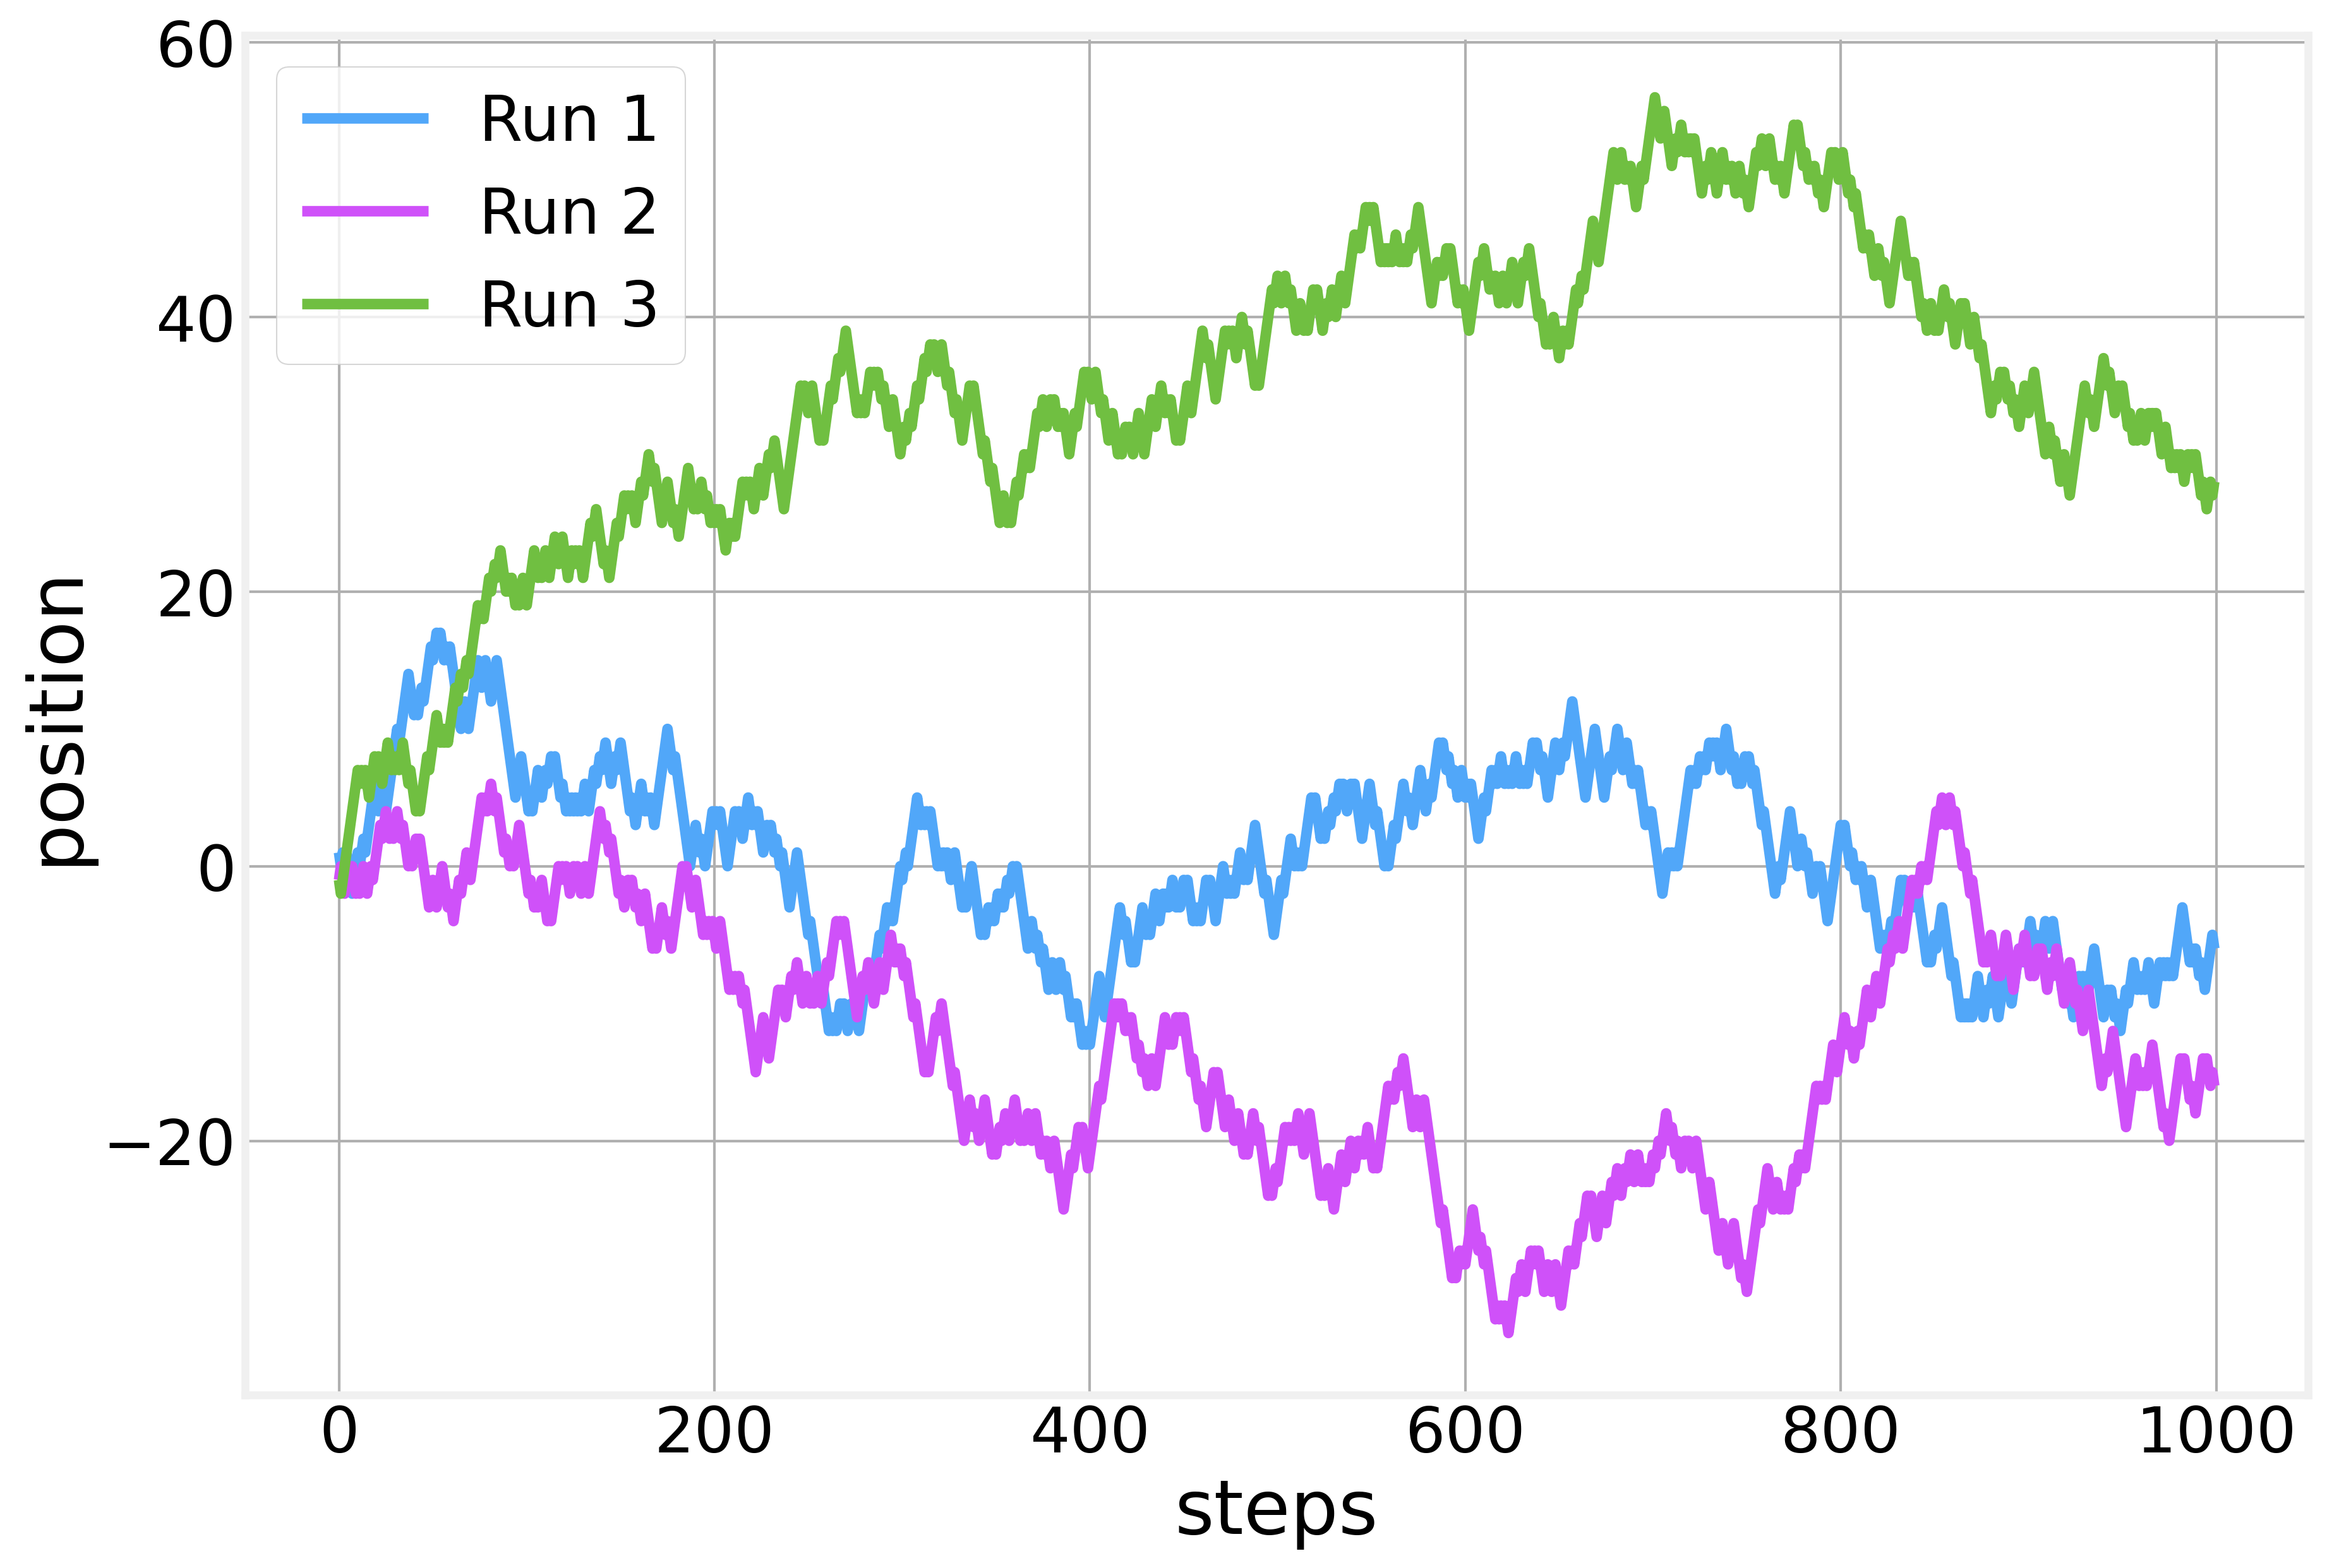

In [15]:
plt.plot(np.arange(1000),position.T[0],label="Run 1")
plt.plot(np.arange(1000),position.T[1],label="Run 2")
plt.plot(np.arange(1000),position.T[2],label="Run 3")
plt.xlabel('steps')
plt.ylabel('position')
plt.legend()

In [5]:
plt.plot(np.arange(50),steps.T[0][:50])
plt.xlabel('steps')
plt.ylabel(r'$\epsilon_i$')

NameError: name 'plt' is not defined

In [15]:
def pearson(x,y):
    meanx=x.mean()
    meany=y.mean()
    stdx=x.std()
    stdy=y.std()

    return np.mean((x-meanx)*(y-meany))/(stdx*stdy)

In [16]:
def acf (x,lag=40):
    return np.array([1]+[pearson(x[:-i],x[i:]) for i in range(1,lag) ])

In [17]:
def acf_ci(acfv,n,alpha=0.05):
    se=[1/np.sqrt(n)]
    se.extend(np.sqrt((1+2*np.cumsum(np.power(acfv[1:-1],2)))/n))
    se=np.array(se)

    se*=stats.norm.ppf(1-alpha/2.)
    return se

In [35]:
def plot_acf(x,lag=40,alpha=0.05):
    acf_val=acf(x,lag)

    plt.vlines(range(lag),0,acf_val)
    plt.scatter(np.arange(lag),acf_val,marker='*')

    plt.xlabel("lag")
    plt.ylabel("ACF")

    ci=acf_ci(acf_val,len(x),alpha)
    plt.fill_between(np.arange(1,ci.shape[0]+1),-ci,ci,alpha=0.25)

In [36]:
def rolling(x,order):
    npoints=x.shape[0]
    running=[]

    for i in range(npoints-order+1):
        running.append(x[i:i+order])
    return np.array(running)

In [37]:
def pacf (x,lag=40):
    y=[]

    for i in range(3,lag+2):
        windows=rolling(x,i)

        xt=windows[:,-1]
        xt_l=windows[:,0]
        inter=windows[:,1:-1]

        lm=LinearRegression(fit_intercept=False).fit(inter,xt)
        xt_fit=lm.predict(inter)

        lm=LinearRegression(fit_intercept=False).fit(inter,xt_l)
        xt_l_fit=lm.predict(inter)

        y.append(pearson(xt-xt_fit,xt_l-xt_l_fit))
    pacf_l=acf(x,2)[1]
    return np.array([1,pacf_l]+y)

In [38]:
def plot_pacf(x,alpha=0.05,lag=40):
    pacf_val=pacf(x,lag)
    plt.vlines(np.arange(lag+1),0,pacf_val)
    plt.scatter(np.arange(lag+1),pacf_val,marker="o")

    plt.xlabel("lag")
    plt.ylabel("PACF")

    ci=acf_ci(pacf_val,len(x))
    plt.fill_between(np.arange(1,ci.shape[0]+1),-ci,ci,alpha=0.25)

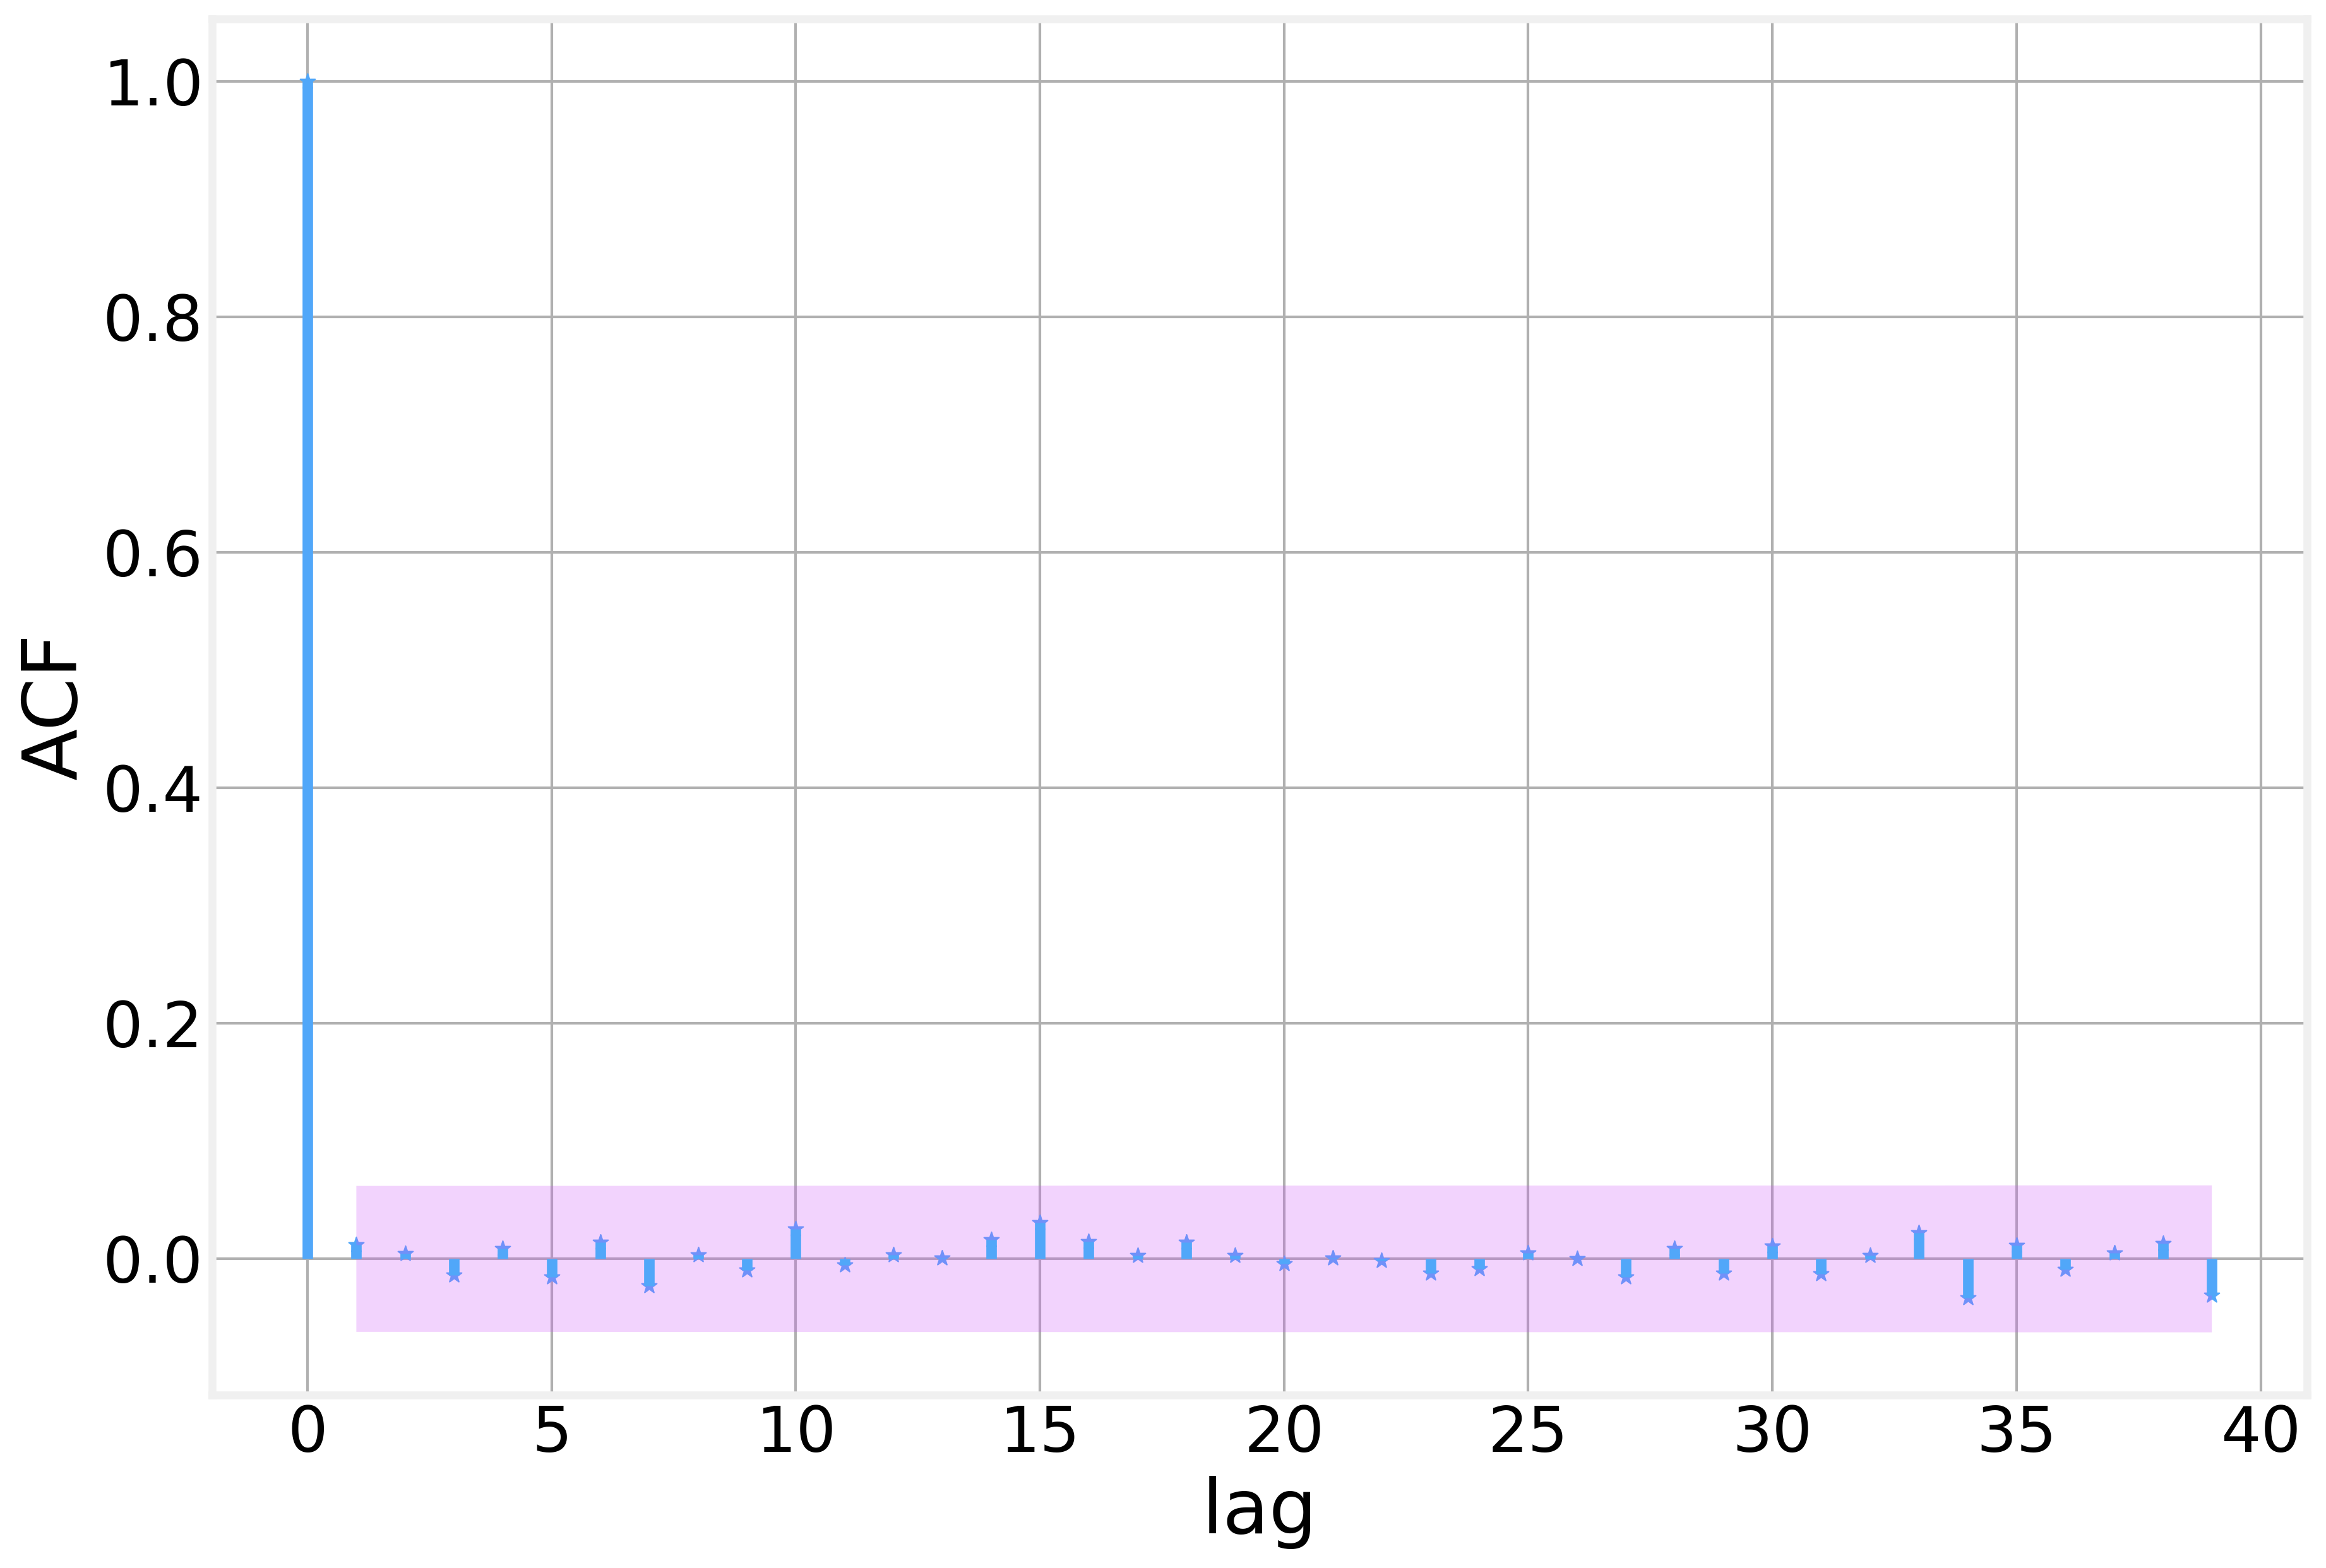

In [22]:
plot_acf(steps)

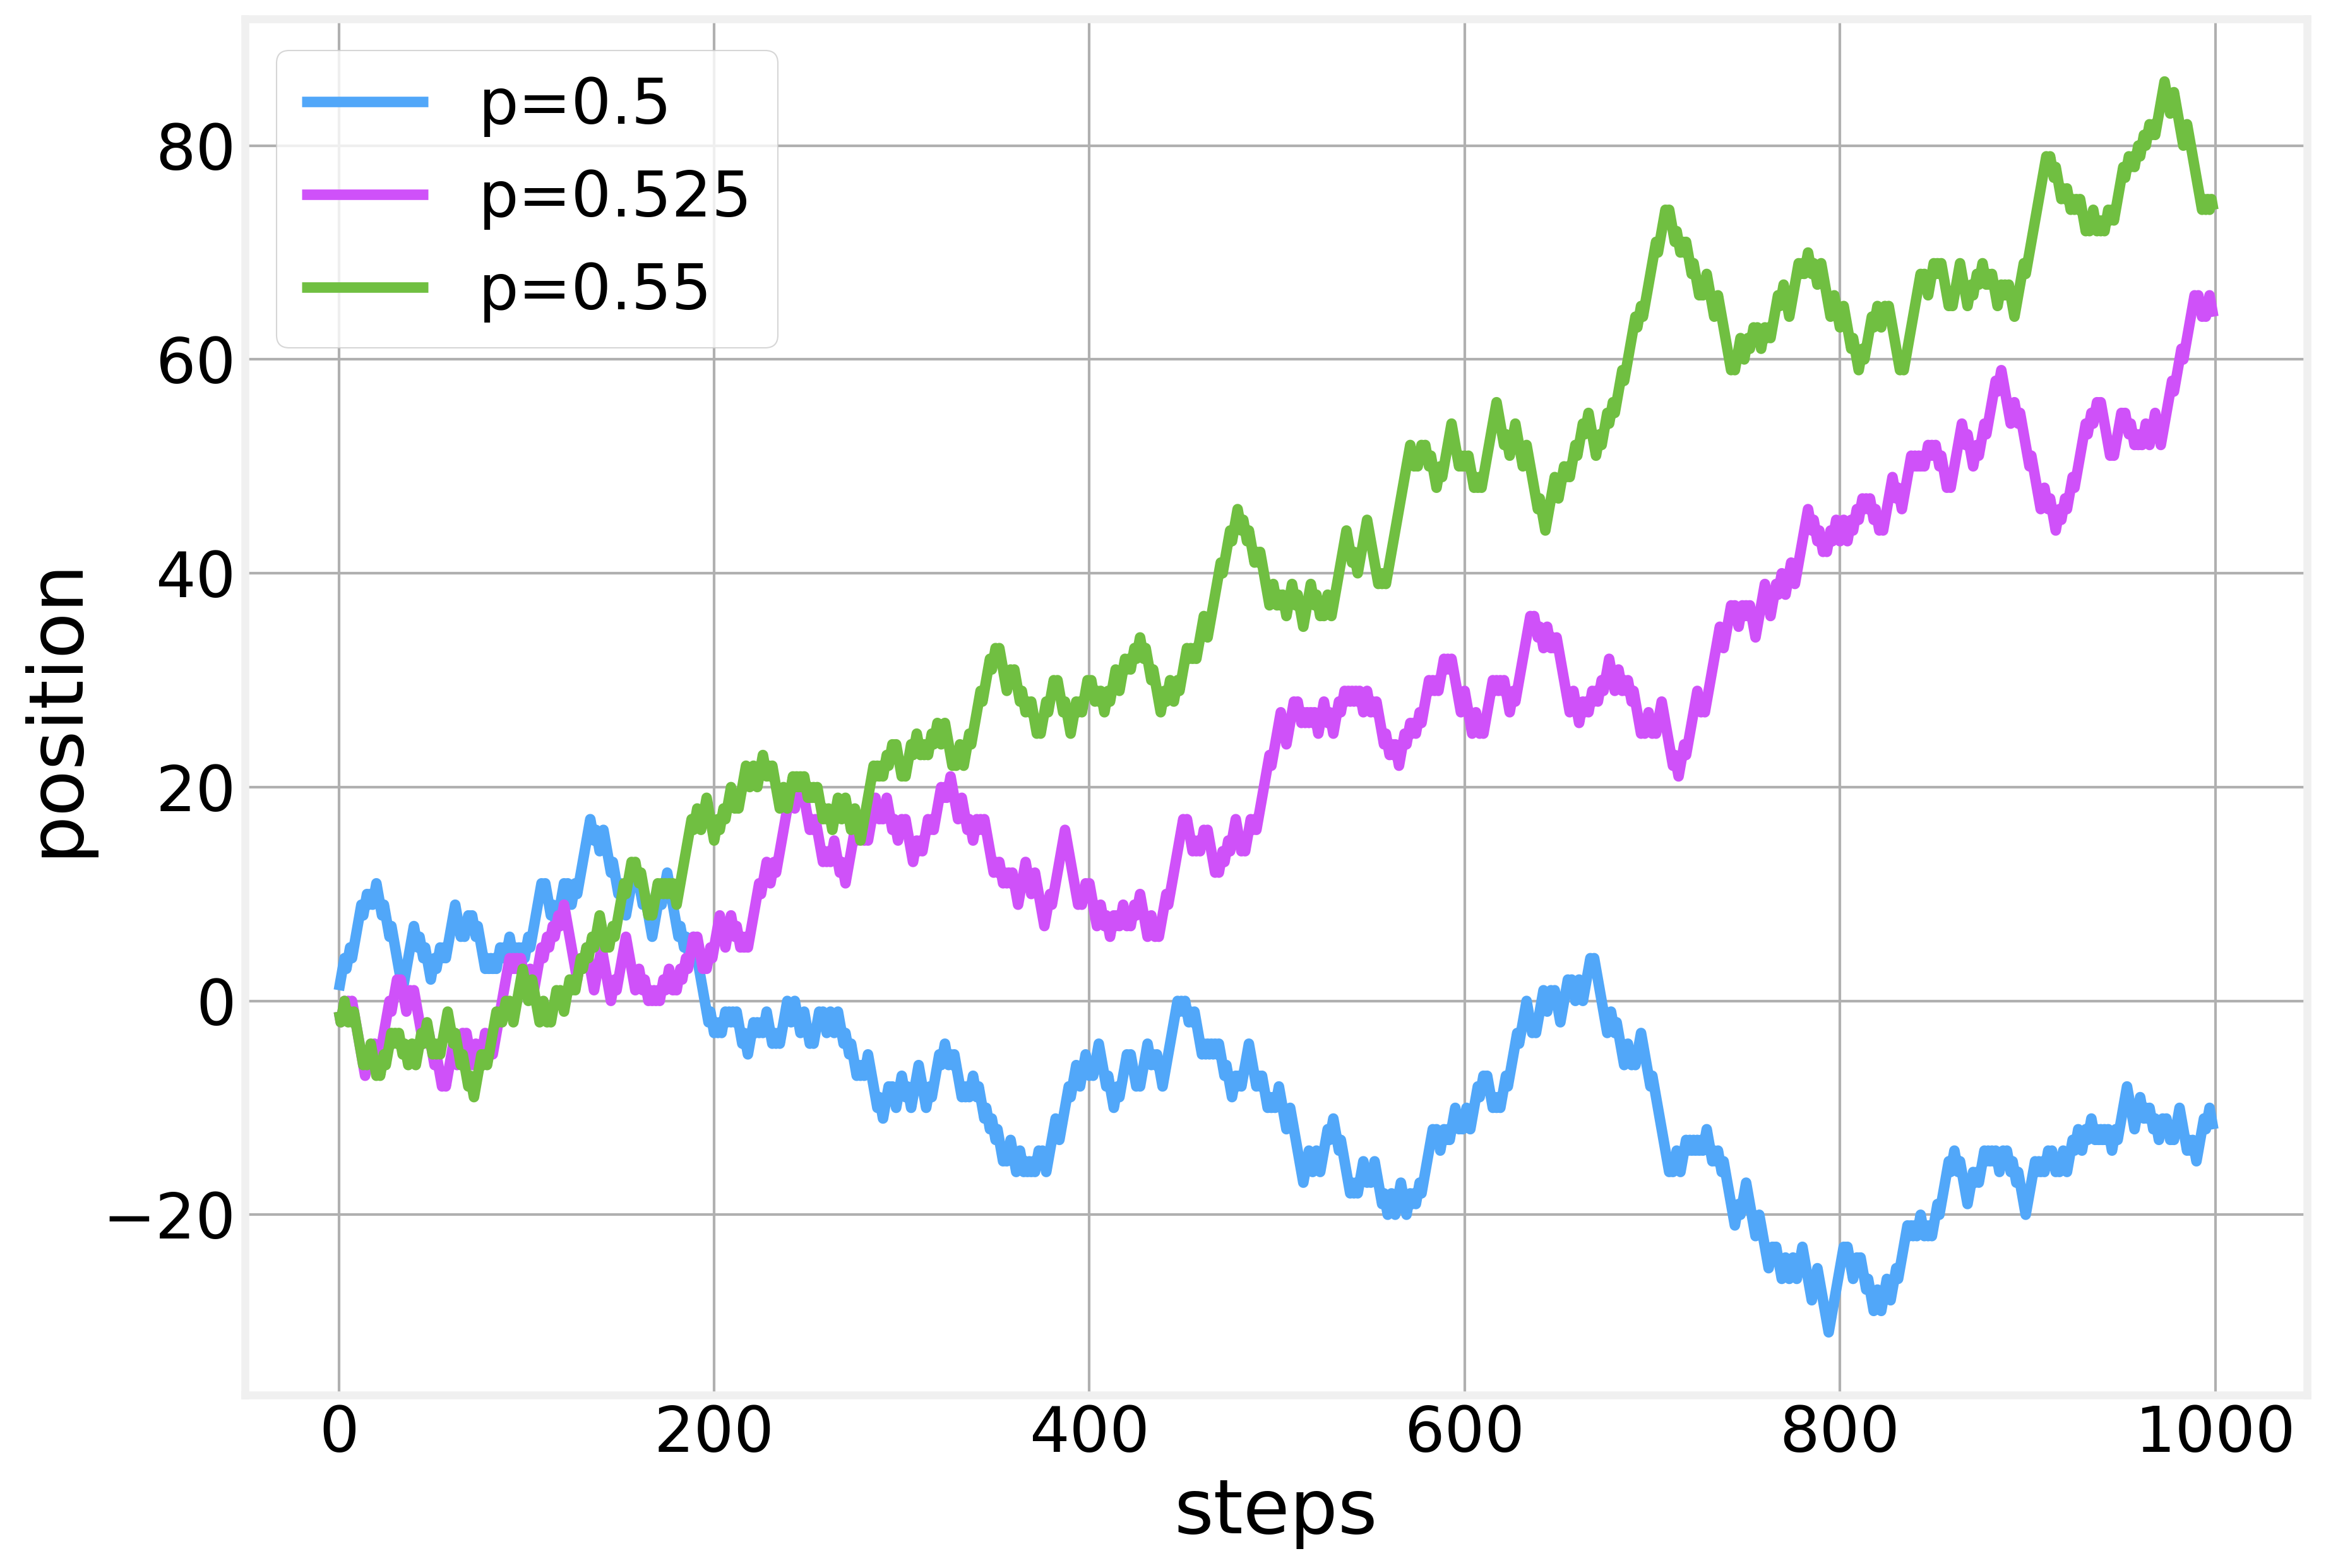

In [26]:
plt.plot(np.arange(1000),flip_coin(1,1000,0.5).cumsum(),label='p=0.5')
plt.plot(np.arange(1000),flip_coin(1,1000,0.525).cumsum(),label='p=0.525')
plt.plot(np.arange(1000),flip_coin(1,1000,0.55).cumsum(),label='p=0.55')
plt.xlabel('steps')
plt.ylabel('position')
plt.legend()


In [29]:
def position_rho(steps,rho):
    position=steps.astype('float').copy()

    for i in range(1,steps.shape[0]):
        position[i]=rho*position[i-1]+steps[i]

    return position

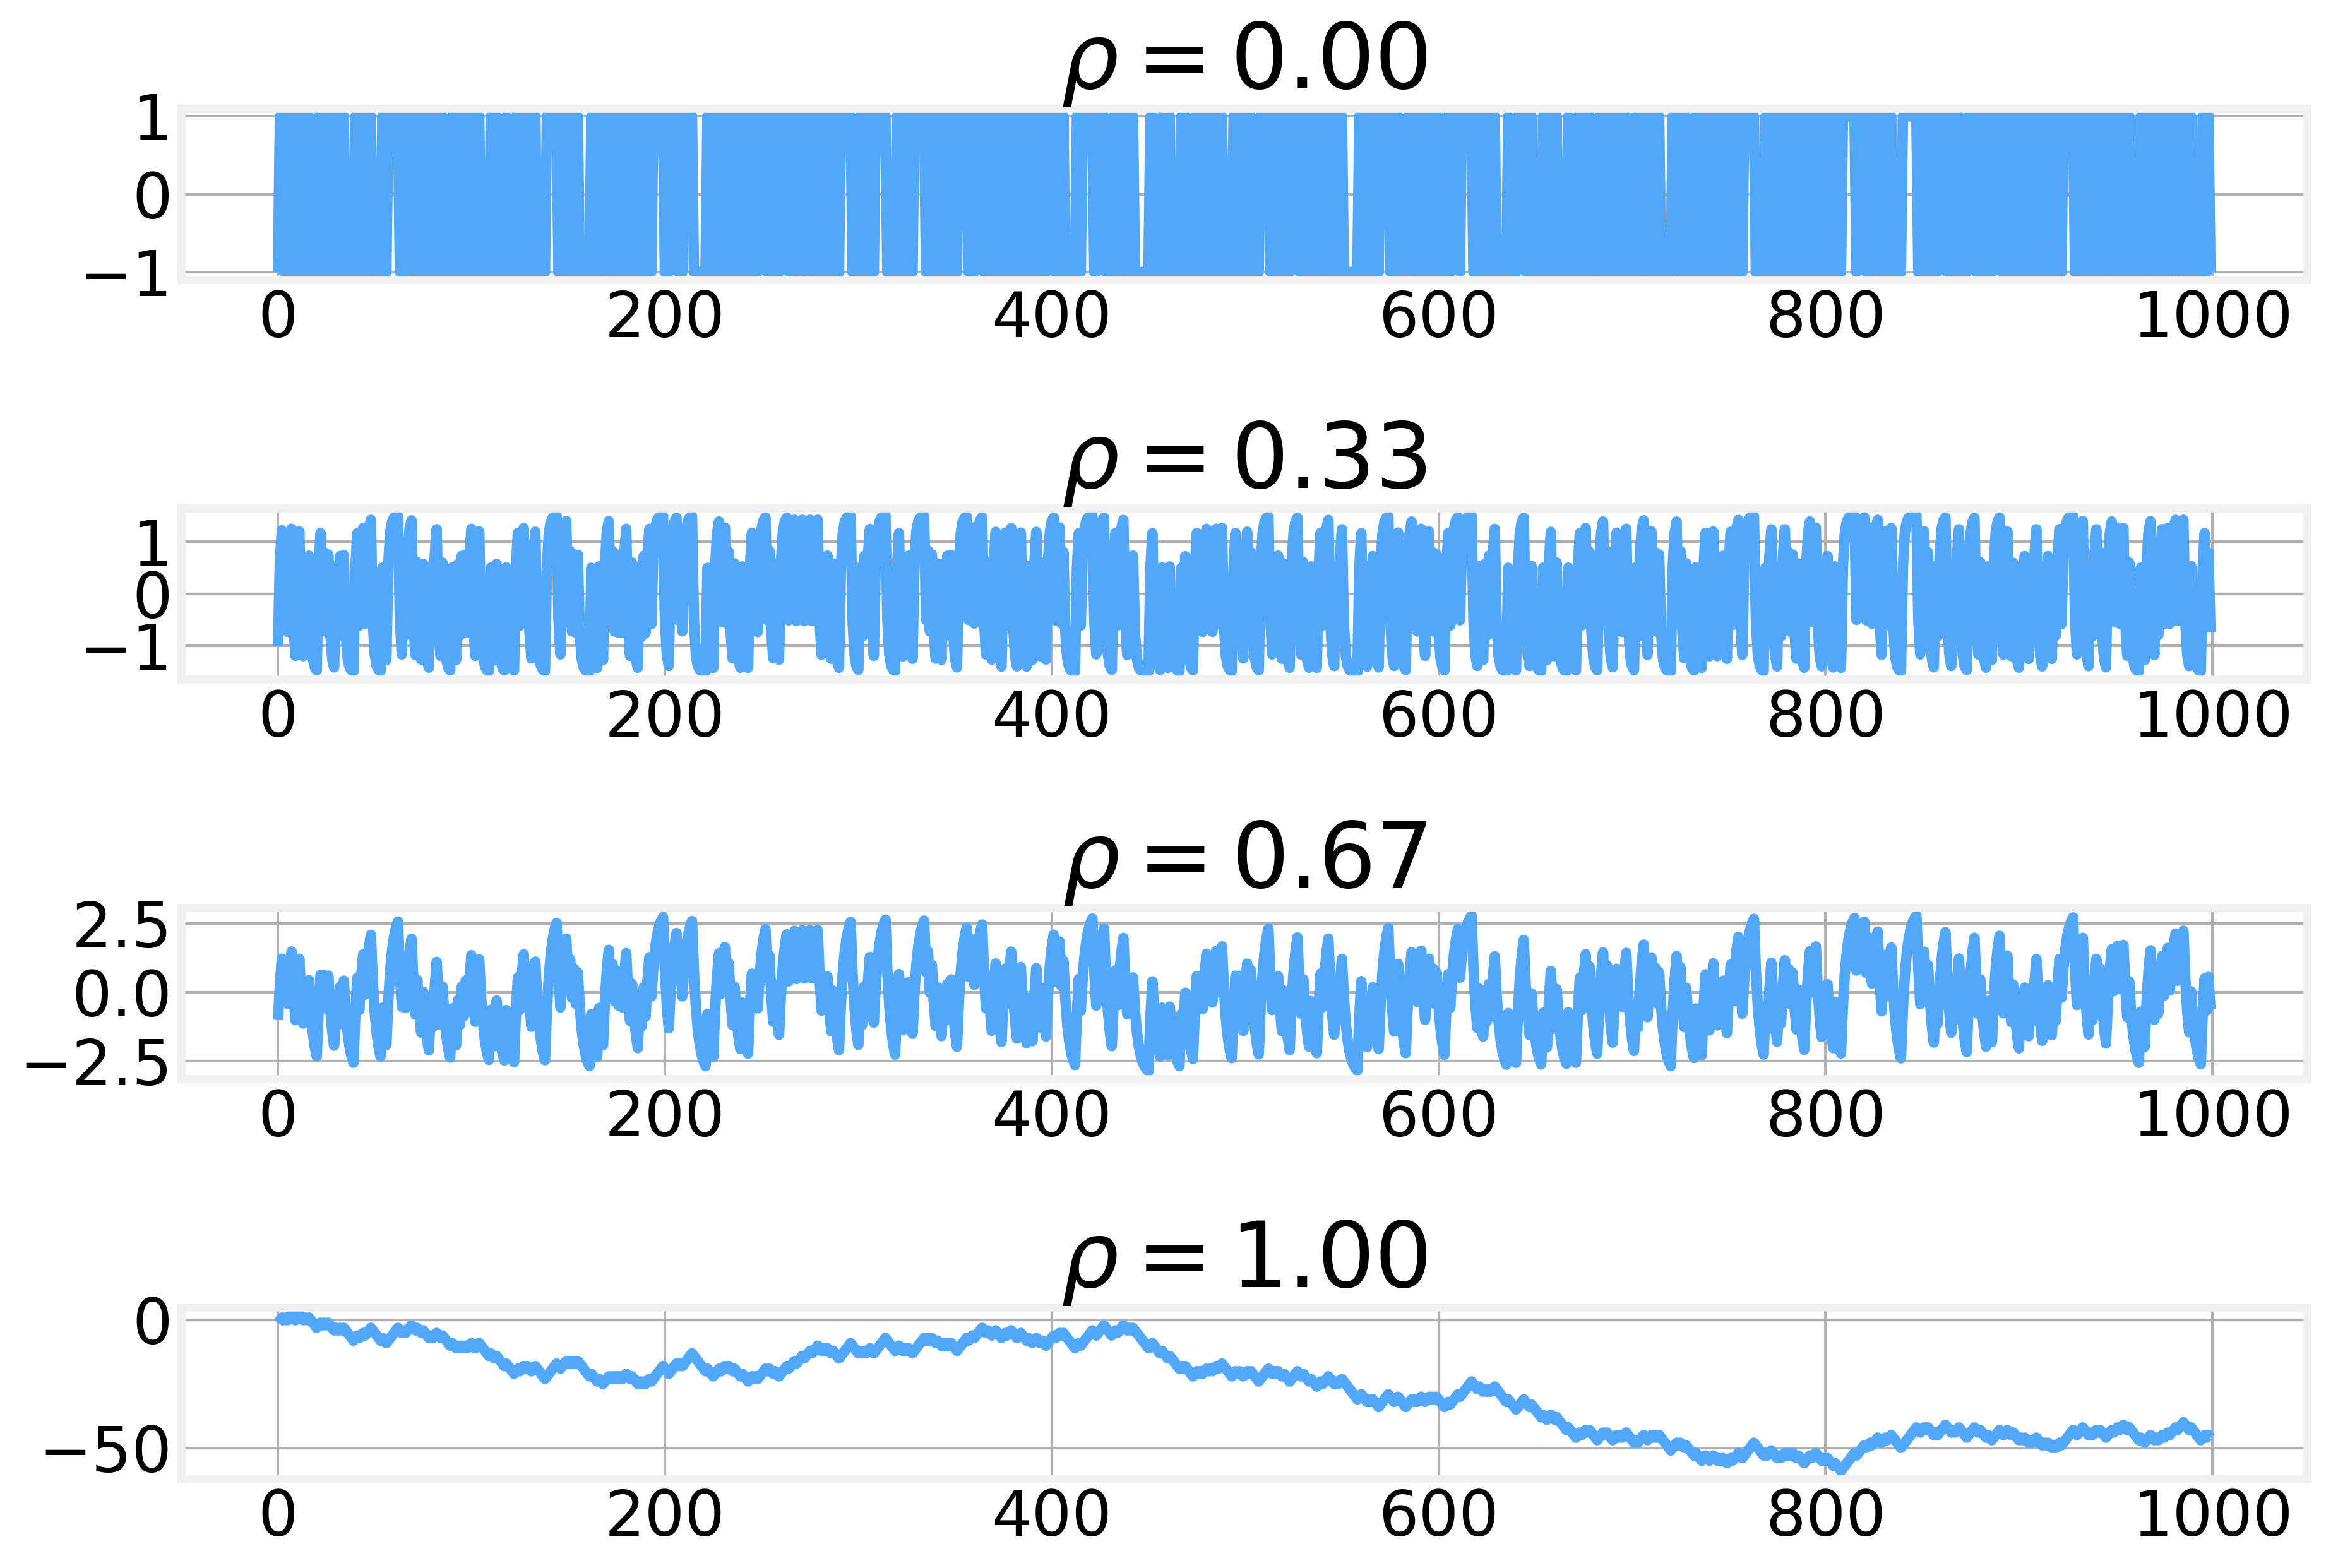

In [30]:
n_steps=4
rho_lst=np.linspace(0,1,n_steps)
steps=flip_coin(1,1000)

fig,axs=plt.subplots(n_steps,1)

for i, rho in enumerate(rho_lst):
    position=position_rho(steps,rho)
    axs[i].plot(position)
    axs[i].set_title(r'$\rho=%1.2f$' %rho)

    fig.tight_layout()

In [33]:
def differentiate(values,d=1):
    x=np.concatenate([[values[0]],values[1:]-values[:-1]])

    if d==1:
        return x
    else:
        return difference(x,d-1)

In [32]:
def dftest(values):
    N=len(values)
    diff=differentiate(values)

    lm=LinearRegression()
    lm.fit(values[:-1],diff[1:])

    return lm.coef_

In [40]:
position=position_rho(steps,0)
dftest(position)

array([[-0.98297549]])

In [41]:
position=position_rho(steps,0.8)
dftest(position)

array([[-0.20406407]])

In [42]:
position=position_rho(steps,1)
dftest(position)

array([[-0.00226359]])